In [3]:
import tensorflow as tf

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, BatchNormalization, LSTM
from keras.optimizers import Adam
from keras.regularizers import l2, l1, l1_l2

# from spektral.layers import GraphConv
# GRaphConv is deprecated, use GCNConv or GCSConv instead
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
from spektral.layers import GCSConv  # as GraphConv
from spektral.layers import GINConv # as GraphConv
from spektral.layers import GCNConv  # as GraphConv

from spektral.utils.convolution import gcn_filter  # For GCNConv
from spektral.utils.convolution import normalized_adjacency  # For GCSConv

import numpy as np
import scipy.sparse
import pandas as pd
import pathlib
import os
import json

from sklearn.model_selection import train_test_split

from utils import *

import numpy as np

In [4]:
# Parameters
l2_reg = 5e-4  # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 32  # Batch size
epochs = 5  # Number of training epochs
es_patience = 200  # Patience fot early stopping

In [5]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [6]:
current_path = pathlib.Path().absolute()
path = current_path.parent

In [7]:
angry_path = path / 'angry_meshpoints'
disgusted_path = path / 'disgusted_meshpoints'
happy_path = path / 'happy_meshpoints'
neutral_path = path / 'neutral_meshpoints'
sad_path = path / 'sad_meshpoints'
surprised_path = path / 'surprised_meshpoints'

path_list = [angry_path, disgusted_path, happy_path, neutral_path, sad_path, surprised_path]

In [8]:
def extrai_dist(path_list, meshs_list, limit=0.1):
    for path in path_list:
        quant_files = len(os.listdir(path))
        count = 0
        for file in os.listdir(path):
            if (count / quant_files) > limit:
                break
            file_path = path / file
            count += 1
            with open(file_path, 'r') as f:
                data = json.load(f)
                meshs_list[path_list.index(path)].append(data)

In [9]:
meshs_surprised = []
meshs_disgusted = []
meshs_happy = []
meshs_neutral = []
meshs_sad = []
meshs_angry = []

meshs_list = [meshs_angry, meshs_disgusted, meshs_happy, meshs_neutral, meshs_sad, meshs_surprised]

extrai_dist(path_list, meshs_list, 1)

print(len(meshs_angry))
print(len(meshs_disgusted))
print(len(meshs_happy))
print(len(meshs_neutral))
print(len(meshs_sad))
print(len(meshs_surprised))

6694
5480
8090
9250
7799
6335


In [12]:
for list in meshs_list:
    print(len(list))

6694
5532
8090
9250
7799
6335


In [9]:
# print(meshs_list)

In [13]:
print(len(meshs_list))

6


In [14]:
# target list
target_list = []
for i in range(6):
    target_list.append(np.full(len(meshs_list[i]), i))

In [12]:
# print(target_list)

In [15]:
# print the unique target labels
print(np.unique(np.concatenate(target_list)))

[0 1 2 3 4 5]


In [16]:
# concatena meshs_list em uma lista só
meshs_list_concat = np.concatenate(meshs_list)
target_list_concat = np.concatenate(target_list)

print(len(meshs_list_concat))

43700


# Iniciando a construção do primeiro GINConv

In [17]:
from sklearn.model_selection import train_test_split


# Split the dataset into train and test sets, shuffling the data
X_train, X_test, y_train, y_test = train_test_split(meshs_list_concat, target_list_concat, test_size=0.2, shuffle=True, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [18]:
# import concat from tensorflow
from tensorflow import concat

# tensor_mesh = concat(meshs_list, axis=0)
# target_tensor = concat(target_list, axis=0)

X__train_tensor = concat(X_train, axis=0)
y__train_tensor = concat(y_train, axis=0)

X__val_tensor = concat(X_val, axis=0)
y__val_tensor = concat(y_val, axis=0)

X__test_tensor = concat(X_test, axis=0)
y__test_tensor = concat(y_test, axis=0)

In [19]:
for target_tensor in [y__train_tensor, y__val_tensor, y__test_tensor]:
    unique_values = np.unique(target_tensor.numpy())
    print("Unique values in target tensor:")
    print(unique_values)
    print()

Unique values in target tensor:
[0 1 2 3 4 5]

Unique values in target tensor:
[0 1 2 3 4 5]

Unique values in target tensor:
[0 1 2 3 4 5]



In [20]:
# tensor_mesh.shape
X__train_tensor.shape

TensorShape([27968, 478, 2])

In [21]:
# target_tensor.shape
y__train_tensor.shape

TensorShape([27968])

In [22]:
X__val_tensor.shape

TensorShape([6992, 478, 2])

In [23]:
y__val_tensor.shape

TensorShape([6992])

In [24]:
n_out = 6  # Number of classes
N = X__train_tensor.shape[-2]  # Number of nodes in the graphs
F = X__train_tensor.shape[-1]  # Original feature dimensionality

In [25]:
N, F

(478, 2)

In [26]:
# import the dropout layer
from tensorflow.keras.layers import Dropout

tanh
signmoid snht
relu
leaky_relu
elu
celu
selu
softplus
softshrink
softsign
tanhshrink
prelu
rrelu
glu
gelu
hardshrink
hardtanh
logsigmoid

In [27]:
adj = tf.sparse.from_dense(tf.convert_to_tensor(get_mediapipe_adjacency_matrix()))

X_in = Input(shape=(N, F))

graph_conv_1 = GINConv(32, activation="tanh", kernel_regularizer=l2(l2_reg), use_bias=True)([X_in, adj])
graph_conv_drop1 = Dropout(0.25)(graph_conv_1)
graph_conv_2 = GINConv(32, activation="tanh", kernel_regularizer=l2(l2_reg), use_bias=True)([graph_conv_drop1, adj])

flatten = Flatten()(graph_conv_2)
fc = Dense(512, activation="relu")(flatten)
fc = Dense(256, activation="mish")(fc)
fc = Dense(128, activation="relu")(fc)
output = Dense(n_out, activation="softmax")(fc)

In [28]:
# Build model
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"]
)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 478, 2)]          0         
                                                                 
 gin_conv (GINConv)          (None, 478, 32)           97        
                                                                 
 dropout (Dropout)           (None, 478, 32)           0         
                                                                 
 gin_conv_1 (GINConv)        (None, 478, 32)           1057      
                                                                 
 flatten (Flatten)           (None, 15296)             0         
                                                                 
 dense (Dense)               (None, 512)               7832064   
                                                                 
 dense_1 (Dense)             (None, 256)               131328

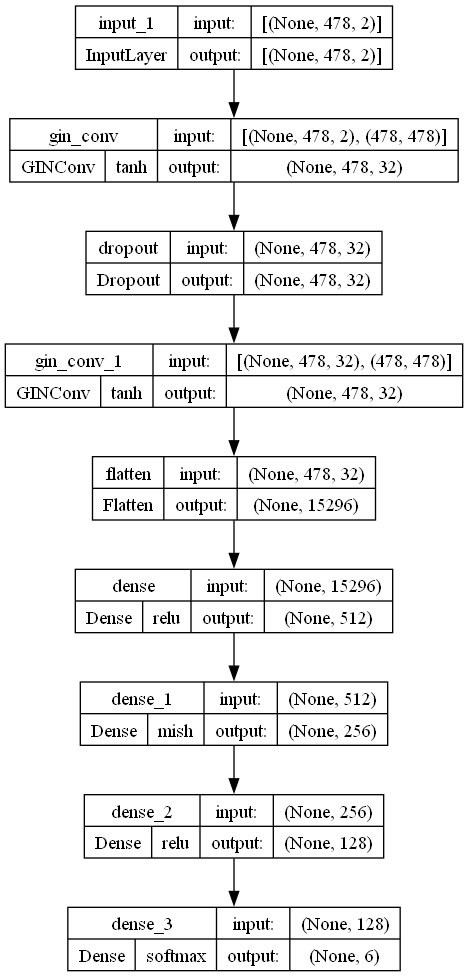

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [52]:
# o tensor_mesh é um tensor de dimensão 3
# o sparse_matrix é um tensor de dimensão 2
# o target_list é um tensor de dimensão 1

# Train model
history = model.fit(
    X__train_tensor,
    y__train_tensor,
    batch_size=batch_size,
    validation_data=(X__val_tensor, y__val_tensor),
    epochs=epochs*5,
    callbacks=[EarlyStopping(patience=es_patience)],
)

Epoch 1/25


873/873 [==============================] - 66s 74ms/step - loss: 1.5862 - acc: 0.4276 - val_loss: 1.3420 - val_acc: 0.4841
Epoch 2/25
873/873 [==============================] - 77s 88ms/step - loss: 1.3197 - acc: 0.4860 - val_loss: 1.2619 - val_acc: 0.5185
Epoch 3/25
873/873 [==============================] - 86s 98ms/step - loss: 1.2786 - acc: 0.5055 - val_loss: 1.2255 - val_acc: 0.5358
Epoch 4/25
873/873 [==============================] - 81s 92ms/step - loss: 1.2381 - acc: 0.5207 - val_loss: 1.2161 - val_acc: 0.5367
Epoch 5/25
873/873 [==============================] - 72s 82ms/step - loss: 1.2195 - acc: 0.5297 - val_loss: 1.1836 - val_acc: 0.5501
Epoch 6/25
873/873 [==============================] - 54s 62ms/step - loss: 1.1958 - acc: 0.5397 - val_loss: 1.1908 - val_acc: 0.5550
Epoch 7/25
873/873 [==============================] - 52s 59ms/step - loss: 1.1843 - acc: 0.5417 - val_loss: 1.1647 - val_acc: 0.5530
Epoch 8/25
873/873 [==============================] - 56s 64ms/step - los

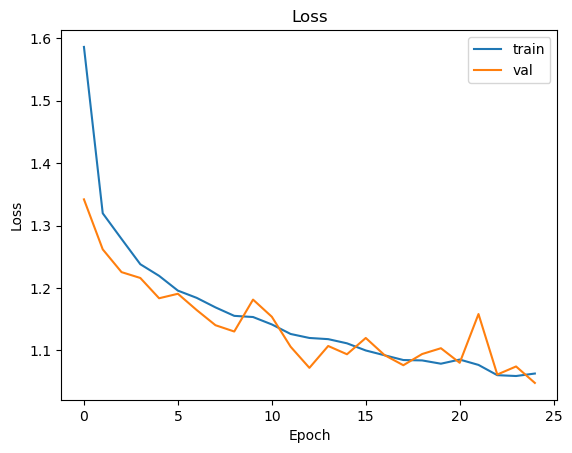

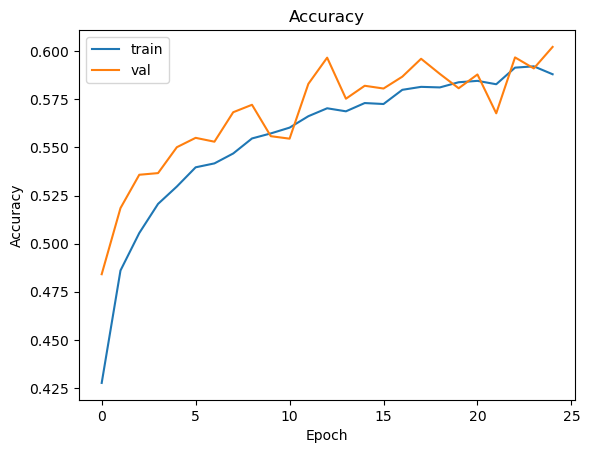

In [62]:
# ploting the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()
plt.savefig('loss.png', dpi=300)
plt.show()

plt.plot(history.history["acc"], label="train")
plt.plot(history.history["val_acc"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.legend()
# save with 300 dpi
plt.savefig('loss_acc.png', dpi=300)
plt.show()

Como o dempenho caiu muita rápido através das epochs, pode ser que o modelo esteja com um overfitting muito grande.

219/219 [==============================] - 2s 10ms/step


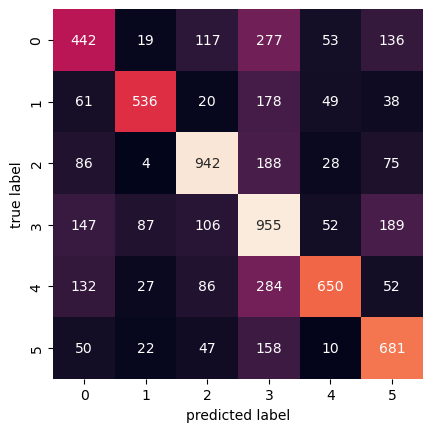

In [61]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X__val_tensor)
y_pred = np.argmax(y_pred, axis=-1)
y_true = y__val_tensor

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt="d", cbar=False)
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

Ta.... ta uma bosta